In [1]:
!git clone https://github.com/boboxa2010/ssl-cv.git

Cloning into 'ssl-cv'...
remote: Enumerating objects: 478, done.
remote: Counting objects: 100% (478/478), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 478 (delta 237), reused 460 (delta 219), pack-reused 0 (from 0)
Receiving objects: 100% (478/478), 92.68 KiB | 1.47 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [2]:
%cd ssl-cv

/content/ssl-cv


In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

In [32]:
def extract_features(model, dataloader, device="cuda"):
    model.eval()
    model.to(device)
    features, labels = [], []
    avgpool_output = {}

    def hook_fn(module, input, output):
        avgpool_output["out"] = output.detach().cpu()

    hook = model.model.avgpool.register_forward_hook(hook_fn)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            imgs = batch["img"].to(device)
            _ = model(imgs)
            feat = torch.flatten(avgpool_output["out"], 1)
            features.append(feat)
            labels.append(batch["labels"])

    hook.remove()
    return torch.cat(features), torch.cat(labels)

In [33]:
def visualize_tsne(features, labels, title):
    features = features.cpu().numpy()
    labels = labels.cpu().numpy()

    tsne = TSNE(n_components=2)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                         c=labels, cmap='tab10', alpha=0.7)

    plt.title(title)
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

In [4]:
torch.manual_seed(228)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [25]:
from src.model import ResNetModel

model = ResNetModel(n_class=4)

model.load_state_dict(torch.load("/content/pretrain-rotations-checkpoint-epoch15.pth", map_location=device, weights_only=False)["state_dict"])

<All keys matched successfully>

In [6]:
from src.datasets import STLDataset

train_dataset = STLDataset(name="train")
test_dataset = STLDataset(name="test")

100%|██████████| 2.64G/2.64G [00:31<00:00, 84.7MB/s]


Parsing STL Dataset metadata for part train...


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 2.64G/2.64G [00:43<00:00, 61.2MB/s]


Parsing STL Dataset metadata for part test...


  0%|          | 0/8000 [00:00<?, ?it/s]

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

In [8]:
train_features, train_labels = extract_features(model, train_loader, device=device)
test_features, test_labels = extract_features(model, test_loader, device=device)

  0%|          | 0/5000 [00:00<?, ?it/s]

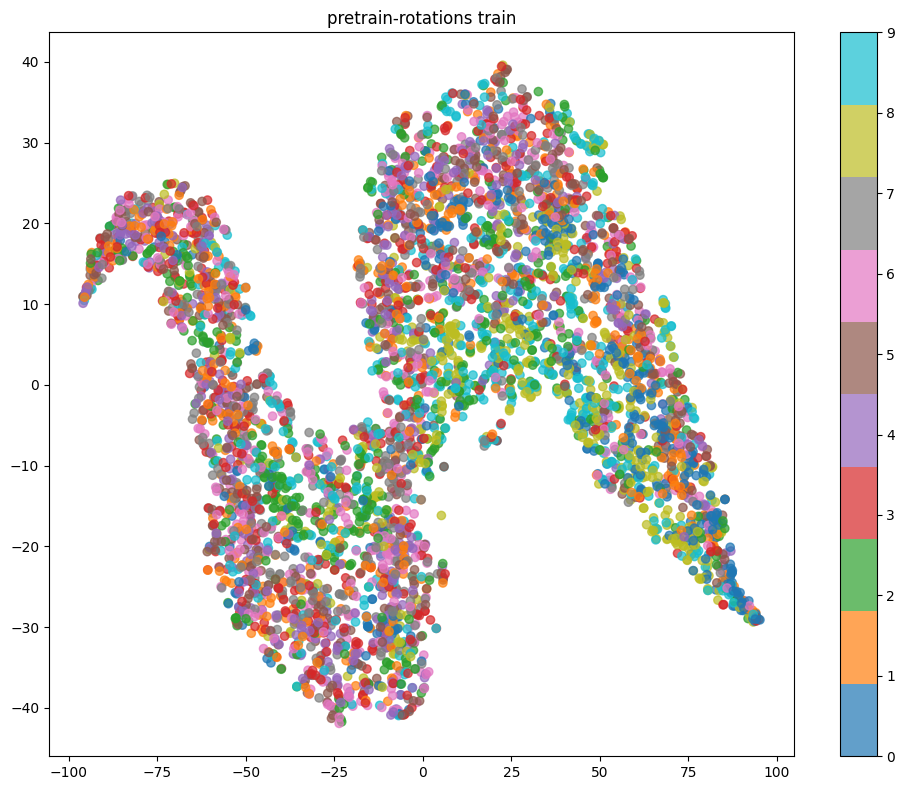

In [34]:
visualize_tsne(train_features, train_labels, title="pretrain-rotations train")

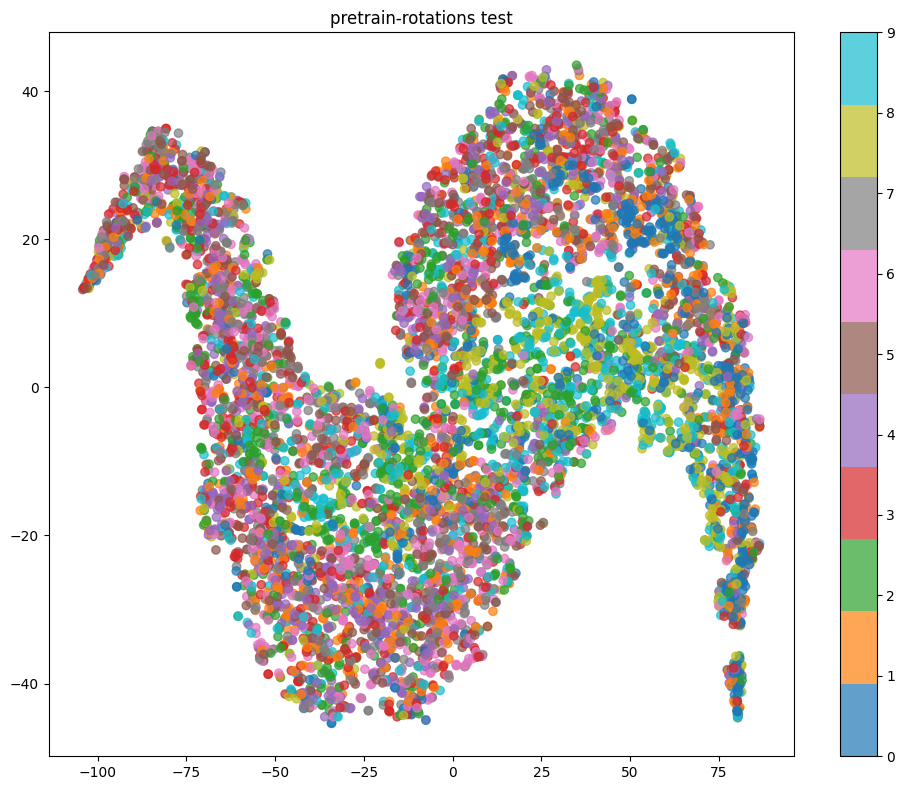

In [35]:
visualize_tsne(test_features, test_labels, title="pretrain-rotations test")

In [36]:
from src.model import ResNetModel

finetune = ResNetModel(n_class=10)

finetune.load_state_dict(torch.load("/content/finetune-model_best.pth", map_location=device, weights_only=False)["state_dict"])

<All keys matched successfully>

In [37]:
train_features, train_labels = extract_features(finetune, train_loader, device=device)
test_features, test_labels = extract_features(finetune, test_loader, device=device)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

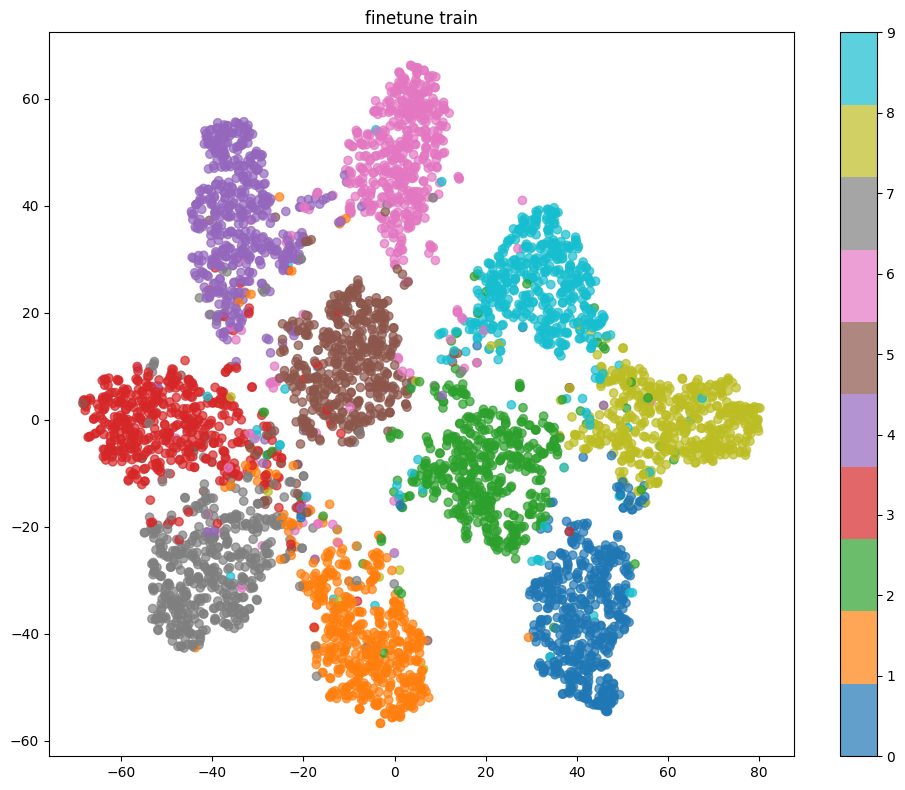

In [38]:
visualize_tsne(train_features, train_labels, title="finetune train")

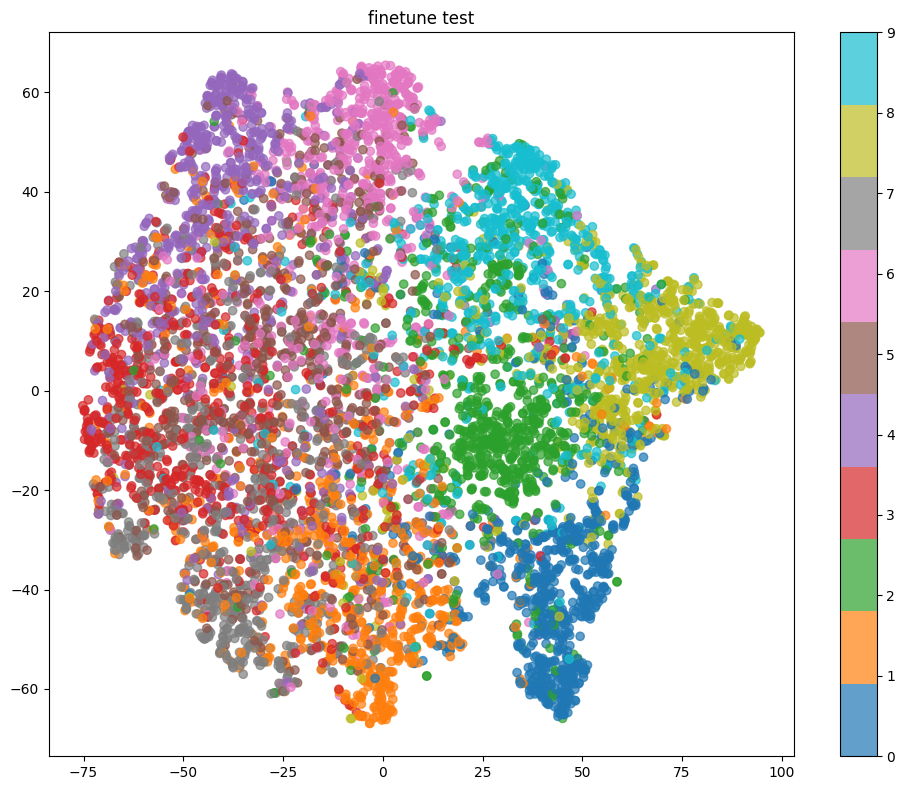

In [39]:
visualize_tsne(test_features, test_labels, title="finetune test")